In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import torch
from torch import nn, optim
import numpy
import h5py
import os
import sys
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import scipy
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_mixture_batches
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from data.synthetic_generator import syntheticMixture3D
from utils.training import train_mixture, train_hmm, train_hmm_subjects
from distributions.Watson_torch import Watson
from distributions.AngularCentralGauss_torch import AngularCentralGaussian as ACG
from models.MixtureModels.MixtureModel_torch import TorchMixtureModel
from models.HMM.HMM_torch import HiddenMarkovModel as HMM
from data.synthetic_generator import syntheticHMM
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib
import matplotlib as mpl
import scipy
global device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using device: {device}')

def get_param(model, show=True):
    para = model.get_model_param()
    
    if show:
        for p_k in para:
            print(p_k)
            print(para[p_k])
            print(10*'---')
    
    return para

def set_color_cycle(self, clist=None):
    if clist is None:
        clist = rcParams['axes.color_cycle']
    self.color_cycle = itertools.cycle(clist)

using device: cuda


# Loading LEiDA

In [3]:
fmri_dataset = '../data/dataset/dataset_all_subjects_LEiDA.hdf5'
dataf = h5py.File(fmri_dataset, mode='r')

num_subjects = len(list(dataf.keys()))
seq_len = 330
obs_dim = 90

leida_full = torch.zeros(num_subjects,seq_len,obs_dim)

for idx, subject in enumerate(list(dataf.keys())):
    leida_full[idx] = torch.tensor(np.array(dataf[subject]))
    
print(leida_full.shape)

torch.Size([199, 330, 90])


# Batching all subject for HMM

In [4]:
leida_train_raw = leida_full[:,:int(seq_len/2),:]
leida_test_raw = leida_full[:,int(seq_len/2):,:]

In [5]:
## Random shuffled batches of 15-20
leida_train = TensorDataset(leida_train_raw)
train_loader = DataLoader(leida_train, batch_size=20, shuffle=True)

leida_test = TensorDataset(leida_test_raw)
test_loader = DataLoader(leida_test, batch_size=20, shuffle = False)

In [26]:
tmodel = HMM(num_states=10, emission_dist=ACG)
tmodel.load_state_dict(torch.load('weights/acg_hmm_0.pth'))
_ = get_param(tmodel)

un_norm_priors
tensor([-2.4658, -0.7477,  0.5850, -1.6365, -1.9568, -1.7343, -0.8151, -0.2071,
         3.0336, -0.8600])
------------------------------
un_norm_Transition_matrix
tensor([[ 2.5109, -1.1023, -1.6089, -1.5608, -1.3647, -1.1870, -1.2566, -1.5955,
         -0.5211, -1.8603],
        [-1.5911,  3.1687, -2.1836, -2.1187, -1.7521, -1.9042, -2.0125, -1.7066,
         -0.7013, -2.0377],
        [-2.6963, -2.6331,  3.1374, -1.9152, -1.8263, -2.1270, -2.4436, -1.6948,
         -0.9630, -1.9921],
        [-2.3073, -1.3557, -1.9038,  2.6559, -2.0957, -1.5589, -2.2232, -2.2370,
         -0.9532, -1.5074],
        [-2.0274, -2.1204, -1.5795, -2.1365,  2.8171, -2.5027, -2.4977, -2.2935,
          0.2096, -2.5836],
        [-2.2994, -1.7077, -1.8990, -2.5911, -1.7439,  2.9106, -2.0779, -1.9128,
         -0.2294, -2.4331],
        [-1.7117, -1.7416, -2.0454, -1.6463, -1.8233, -1.4014,  2.6263, -1.6438,
         -1.1831, -1.8703],
        [-1.9082, -2.5879, -2.1916, -2.3767, -2.5786, -2.5

## HMM v2 training and test - loop

In [43]:
def hmm_train_and_eval(model, train_dataloader, test_dataloader, optimizer, num_epoch, sigle_model=False):
    
    model = model.to(device)
    
    train_results = np.zeros(num_epoch)
    test_results = np.zeros(num_epoch)

    for epoch in tqdm(range(num_epoch), leave=sigle_model, desc='Epoch'):
    
        # Tranining model
        running_train = 0
        model.train(True)
        for idx, data in enumerate(tqdm(train_dataloader,leave=False, desc="Train")):
            
            batch_leida_vectors = data[0].to(device)
            
            
            optimizer.zero_grad()
            
            NegativeLogLikelihood = - model(batch_leida_vectors)
            
            NegativeLogLikelihood.backward()
            optimizer.step()
            
            
            running_train += NegativeLogLikelihood

        train_results[epoch] = running_train

        
        #Test/Evaluation
        running_test = 0
        model.eval()
        with torch.no_grad():
            for idx, data in enumerate(tqdm(test_dataloader,leave=False, desc="Test")):
                test_leida_vectors = data[0].to(device)
                test_NegativeLogLikelihood = - model(test_leida_vectors)
                
                running_test += test_NegativeLogLikelihood
                
            test_results[epoch] = running_test
        #if epoch % 40 == 0:
#             torch.save(model.state_dict(), f'weights/acg_hmm_{epoch}.pth')
#             print(f'Model was saved! ({epoch})')
            
    return train_results, test_results

# Hidden Markov Model - ACG

In [33]:
lr_eval = np.arange(0.08, 1, 0.12)[:3]
lr_eval = [0.08, 0.35, 0.65, 0.95, 1.5]
print(lr_eval)

[0.08, 0.35, 0.65, 0.95, 1.5]


## ACG Learning rate

In [32]:
device = 'cpu'
epochs = 50
train_lr_results = np.zeros((len(lr_eval), epochs))
test_lr_results = np.zeros((len(lr_eval), epochs))

for idx, lr in enumerate(tqdm(lr_eval)):
    
    model = HMM(num_states=8, emission_dist=ACG) #New init of model
    adam = optim.Adam(model.parameters(), lr=lr)
    
    train_res, test_res = hmm_train_and_eval(model, train_loader, test_loader, optimizer=adam, num_epoch=epochs)
    
    train_lr_results[idx] = train_res
    test_lr_results[idx] = test_res

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

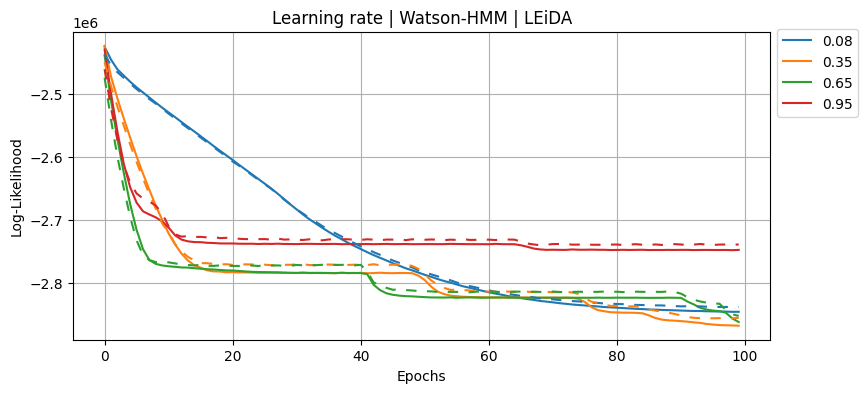

In [33]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(train_lr_results.T)
plt.gca().set_prop_cycle(None)
plt.plot(test_lr_results.T, linestyle=(0,(5,5)))
plt.title('Learning rate | Watson-HMM | LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(lr_eval, 3), ncol=1, bbox_to_anchor=(1.01, 1.01), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

# ACG-HMM - best model

In [44]:
device = 'cpu'
epochs = 30

acg_hmm = HMM(num_states=10, emission_dist=ACG)

adam = optim.Adam(acg_hmm.parameters(), lr=0.015)
train_res, test_res = hmm_train_and_eval(acg_hmm, train_loader, test_loader, optimizer=adam, num_epoch=epochs, sigle_model=True)

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

Train:   0%|          | 0/10 [00:00<?, ?it/s]

Test:   0%|          | 0/10 [00:00<?, ?it/s]

In [29]:
torch.save(acg_hmm.state_dict(), 'weights/acg_hmm_300.pth')

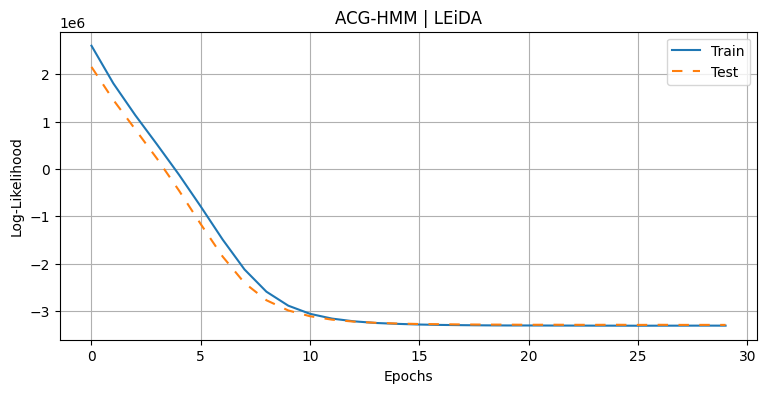

In [45]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(train_res[:50])
#plt.gca().set_prop_cycle(None)
plt.plot(test_res[:50], linestyle=(0,(5,5)))
plt.title('ACG-HMM | LEiDA')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(['Train','Test'], ncol=1)
plt.grid()
plt.show()

In [31]:
print(test_res[-1])

-3291714.25


In [96]:
tmodel = HMM(num_states=10, emission_dist=Watson)
tmodel.load_state_dict(torch.load('weights/watson_hmm_500.pth'))

HiddenMarkovModel(
  (emission_models): ModuleList(
    (0): Watson
    (1): Watson
    (2): Watson
    (3): Watson
    (4): Watson
    (5): Watson
    (6): Watson
    (7): Watson
    (8): Watson
    (9): Watson
  )
  (softplus): Softplus(beta=1, threshold=20)
  (logsoftmax_transition): LogSoftmax(dim=1)
  (logsoftmax_prior): LogSoftmax(dim=0)
)

In [105]:
tmodel_param = get_param(tmodel)

un_norm_priors
tensor([1.6517, 1.9301, 2.6844, 1.1967, 0.7149, 2.7219, 1.9978, 1.3568, 2.6976,
        1.4980])
------------------------------
un_norm_Transition_matrix
tensor([[ 4.2216,  0.2029,  0.0710, -0.1268,  0.0798,  0.0207, -0.1687, -0.5922,
         -1.5250, -0.7996],
        [ 2.8798,  6.4960,  2.0468,  1.7281,  1.6337,  1.5544,  2.6834,  2.0103,
          2.4166,  2.4234],
        [ 2.2785,  1.4252,  6.4422,  1.9989,  2.2219,  0.5876,  2.2013,  1.8542,
          2.4475,  2.1782],
        [ 1.7485,  0.8617,  0.7882,  5.7184,  1.2424,  0.6693,  1.4764,  1.2016,
          1.6615,  1.6643],
        [ 3.1701,  2.6387,  2.8563,  3.1966,  7.4424,  3.0490,  2.6797,  3.4935,
          2.8920,  2.3620],
        [ 3.3043,  1.9104,  3.1040,  2.0903,  3.5156,  7.2155,  3.7004,  2.9898,
          3.4594,  3.1702],
        [ 2.7173,  3.8139,  2.8684,  3.3161,  3.2434,  3.8820,  7.6200,  2.1767,
          1.9411,  2.8613],
        [ 1.9677,  1.8980,  2.2084,  1.4029,  2.0061,  2.0703,  2.35

In [36]:
m1_param = get_param(acg_hmm, show=True)

un_norm_priors
tensor([-3.2945, -4.0199, -4.0261, -3.8564, -3.7140, -2.2766, -3.4474, 10.3507,
        -3.9238, -3.4595])
------------------------------
un_norm_Transition_matrix
tensor([[ 4.8547, -3.9526, -4.1390, -3.8476, -4.4799, -2.8268, -3.9523, -2.3117,
         -4.1008, -3.6639],
        [-2.1105,  3.9236, -2.7158, -3.0098, -3.1387, -1.9837, -2.7354, -2.5649,
         -2.7473, -2.0713],
        [-2.1454, -2.2489,  3.6565, -2.2954, -2.1881, -1.6873, -1.9278, -2.0788,
         -1.7525, -2.5952],
        [-2.1323, -2.7948, -2.4503,  4.1097, -2.5807, -3.0481, -3.2757, -1.3273,
         -2.7827, -2.2206],
        [-2.2971, -2.1474, -2.4239, -2.0099,  3.7039, -1.7337, -1.9937, -2.1486,
         -2.1185, -2.8922],
        [-4.9291, -4.9996, -4.8381, -5.1271, -4.5216,  5.1515, -4.9638,  1.6207,
         -5.3901, -5.1653],
        [-3.1022, -3.5029, -3.0860, -3.3661, -3.1960, -2.0625,  3.9183, -2.3838,
         -2.6036, -2.4156],
        [-7.4160, -6.3600, -6.8772, -6.4633, -6.9872, -6.1

In [39]:
t = m1_param['un_norm_Transition_matrix']
p = m1_param['un_norm_priors']

In [70]:
t.softmax(dim=1)

tensor([[0.9027, 0.0162, 0.0142, 0.0117, 0.0143, 0.0135, 0.0112, 0.0073, 0.0029,
         0.0060],
        [0.0238, 0.8855, 0.0104, 0.0075, 0.0068, 0.0063, 0.0196, 0.0100, 0.0150,
         0.0151],
        [0.0140, 0.0060, 0.9021, 0.0106, 0.0133, 0.0026, 0.0130, 0.0092, 0.0166,
         0.0127],
        [0.0170, 0.0070, 0.0065, 0.8996, 0.0102, 0.0058, 0.0129, 0.0098, 0.0156,
         0.0156],
        [0.0126, 0.0074, 0.0092, 0.0130, 0.9061, 0.0112, 0.0077, 0.0175, 0.0096,
         0.0056],
        [0.0173, 0.0043, 0.0142, 0.0051, 0.0214, 0.8641, 0.0257, 0.0126, 0.0202,
         0.0151],
        [0.0067, 0.0201, 0.0078, 0.0122, 0.0114, 0.0215, 0.9054, 0.0039, 0.0031,
         0.0078],
        [0.0118, 0.0110, 0.0150, 0.0067, 0.0123, 0.0131, 0.0174, 0.8784, 0.0144,
         0.0200],
        [0.0043, 0.0132, 0.0168, 0.0141, 0.0091, 0.0142, 0.0057, 0.0155, 0.9047,
         0.0024],
        [0.0069, 0.0138, 0.0108, 0.0166, 0.0110, 0.0129, 0.0110, 0.0112, 0.0037,
         0.9021]])

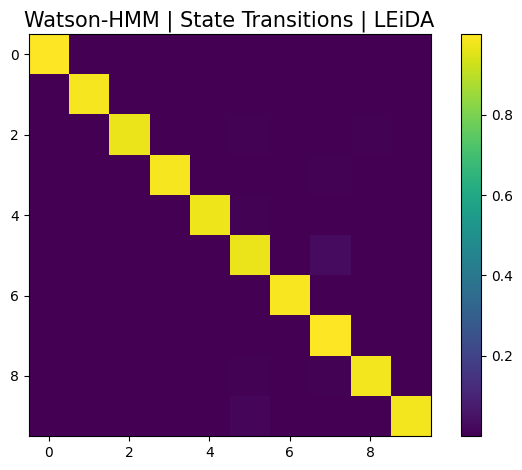

In [41]:
fig, ax = plt.subplots()
im = ax.imshow(t.softmax(dim=1))

# Show all ticks and label them with the respective list entries
# ax.set_xticks(np.arange(len(farmers)), labels=farmers)
# ax.set_yticks(np.arange(len(vegetables)), labels=vegetables)
# # Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#          rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
# for i in range(len(vegetables)):
#     for j in range(len(farmers)):
#         text = ax.text(j, i, harvest[i, j],
#                        ha="center", va="center", color="w")

ax.set_title("Watson-HMM | State Transitions | LEiDA", size=15)
fig.tight_layout()
plt.colorbar(im, ax=ax)
plt.show()

## Viterbi decode - Watson | LEiDA

### OBSERVE CLUSTER SWITCH

In [108]:
best_paths, paths_probs =tmodel.viterbi2(leida_full[10:15])

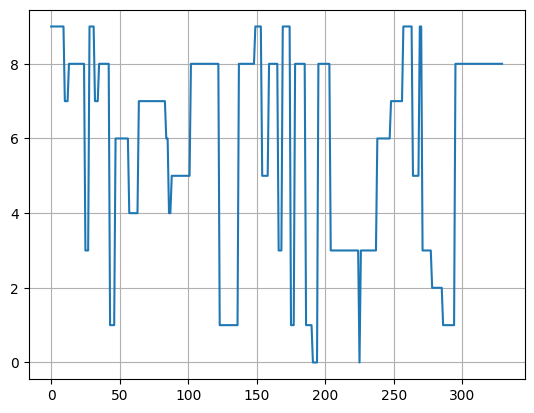

In [112]:
plt.close()
%matplotlib inline
plt.plot(best_paths[1])
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


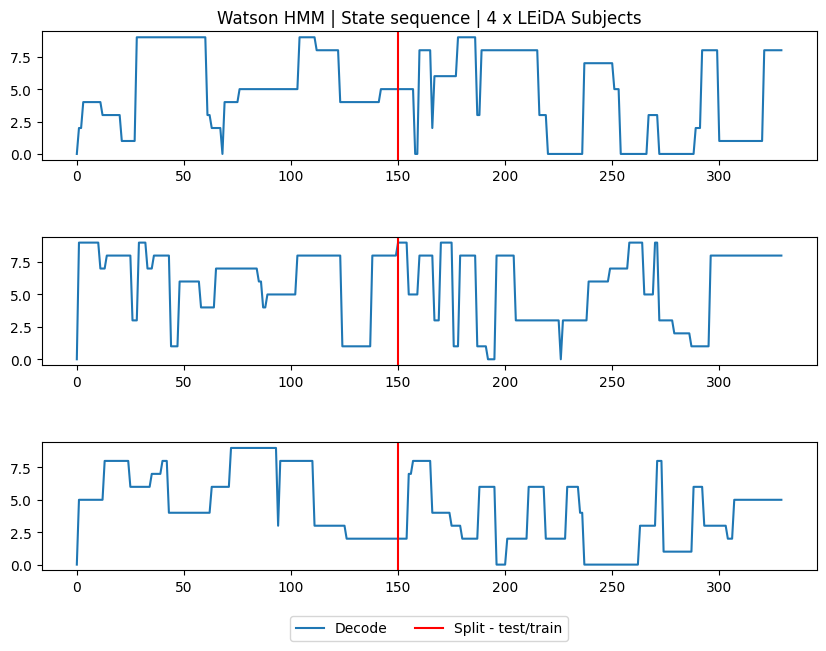

In [104]:
sub = 4
decode_path = list(best_paths[sub])
decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(10,7))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(decode_path[:-1], label='Decode')
    ax[sub].axvline(150, color='r', label='Split - test/train')

    #ax[sub].yticks([0,1,2])
    ax[0].set_title('Watson HMM | State sequence | 4 x LEiDA Subjects')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## Watson-HMM | NMI score

In [117]:
from sklearn.metrics import normalized_mutual_info_score as NMI

In [228]:
NMI(Z_seq[sub],decode_path[:-1])

0.5397459496727025

<IPython.core.display.Javascript object>


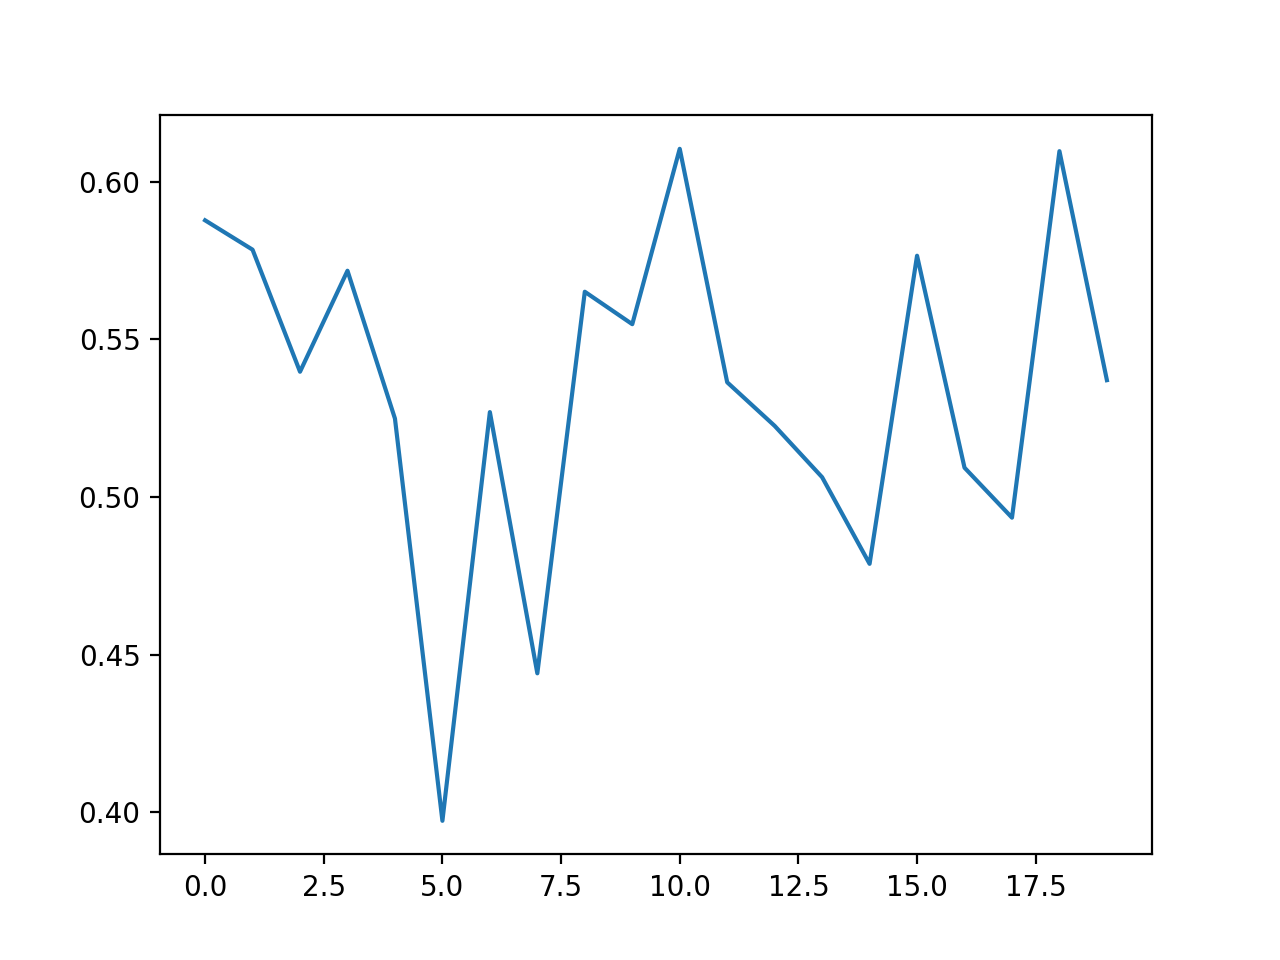

Average Watson NMI: 0.533576335840456


In [234]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')

# ACG-HMM | Synthetic3D

In [161]:
model_dist = ACG
model = HMM(num_states=3, observation_dim=3, emission_dist=model_dist)

_ = get_param(model)

un_norm_priors
tensor([0.9173, 0.6097, 0.5565])
------------------------------
un_norm_Transition_matrix
tensor([[0.6103, 0.4260, 0.8132],
        [0.9944, 0.5229, 0.3641],
        [0.8209, 0.1309, 0.3439]])
------------------------------
emission_model_0
tensor([[ 0.6015,  0.3338, -0.0070],
        [ 0.3338,  0.8665,  0.8257],
        [-0.0070,  0.8257,  1.6651]])
------------------------------
emission_model_1
tensor([[ 0.8731, -0.3004, -0.7644],
        [-0.3004,  1.9117,  3.3430],
        [-0.7644,  3.3430,  6.6568]])
------------------------------
emission_model_2
tensor([[ 1.6294, -1.0954, -1.0589],
        [-1.0954,  1.8851,  1.7557],
        [-1.0589,  1.7557,  2.3355]])
------------------------------


In [193]:
hmm_eval_LR = np.arange(0.08, 1, 0.08)[4:5]
hmm_eval_LR = [0.35,0.45,0.55,0.65,0.7]
print(hmm_eval_LR)

[0.35, 0.45, 0.55, 0.65, 0.7]


In [194]:
int_epoch = 100
acg_hmm_LR_results = np.zeros((len(hmm_eval_LR),int_epoch))
best_like = 4000.
for idx, LR in enumerate(tqdm(hmm_eval_LR)):
    acg_hmm = HMM(num_states=3, observation_dim=3, emission_dist=model_dist) #New init of model
    Adam_optimizer = optim.Adam(acg_hmm.parameters(), lr=LR)
    likehood = train_hmm(acg_hmm, data=synX_emission, optimizer=Adam_optimizer, num_epoch=int_epoch, keep_bar=False)
    acg_hmm_LR_results[idx] = likehood
    
    if likehood[-1] < best_like:
        best_model = acg_hmm
        best_like = likehood[-1]
        best_idx = idx
        
    acg_hmm_LR_results[idx] = likehood

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [200]:
print(best_idx)
print(acg_hmm_LR_results[best_idx,-1])

1
2572.8603515625


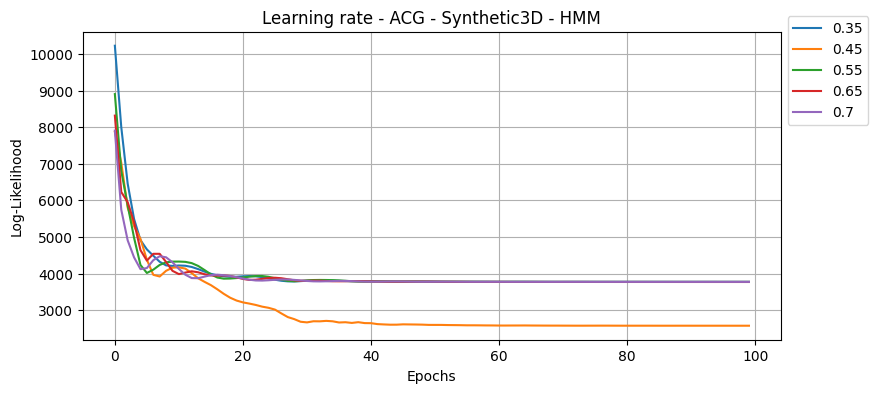

In [197]:
plt.close()
%matplotlib inline
plt.figure(figsize=(9, 4))
plt.plot(acg_hmm_LR_results.T)
plt.title('Learning rate - ACG - Synthetic3D - HMM')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.legend(np.round(hmm_eval_LR, 3), ncol=1, bbox_to_anchor=(1.01, 1.05), loc='upper left', borderaxespad=0.)
plt.grid()
plt.show()

In [201]:
acg_hmm_LR_results[:,-1]

array([3771.75195312, 2572.86035156, 3770.29101562, 3768.36914062,
       3770.71850586])

### Best lr ACG HMM train

In [202]:
acgbest_param = get_param(best_model)

un_norm_priors
tensor([ 2.1921, -5.4010,  1.3396])
------------------------------
un_norm_Transition_matrix
tensor([[0.3971, 0.4432, 0.2327],
        [0.2331, 0.6659, 0.1756],
        [0.5760, 0.4823, 0.4948]])
------------------------------
emission_model_0
tensor([[ 3.4026e+01,  3.8848e+00, -1.4942e-01],
        [ 3.8848e+00,  4.7790e-01, -1.7807e-02],
        [-1.4942e-01, -1.7807e-02,  3.8401e-02]])
------------------------------
emission_model_1
tensor([[0.0693, 0.0362, 0.1542],
        [0.0362, 0.0937, 0.2414],
        [0.1542, 0.2414, 1.1341]])
------------------------------
emission_model_2
tensor([[ 1.1644e-02,  1.7637e-04, -3.2642e-04],
        [ 1.7637e-04,  1.9032e+00,  3.8778e+00],
        [-3.2642e-04,  3.8778e+00,  1.7774e+01]])
------------------------------


In [208]:
learned_sigma = torch.stack([acgbest_param[f'emission_model_{idx}'] for idx in range(acgbest.N)])
learned_pi = acgbest_param['un_norm_priors'] + torch.tensor([0.,7.,0.])
learned_pi = scipy.special.softmax(np.array(learned_pi),0)
print(learned_pi)

[0.50531155 0.27924424 0.21544424]


### Syn vs Learned ACG on the sphere3d | From HMM

Simulate 3000 point from 3 of clusters


<IPython.core.display.Javascript object>


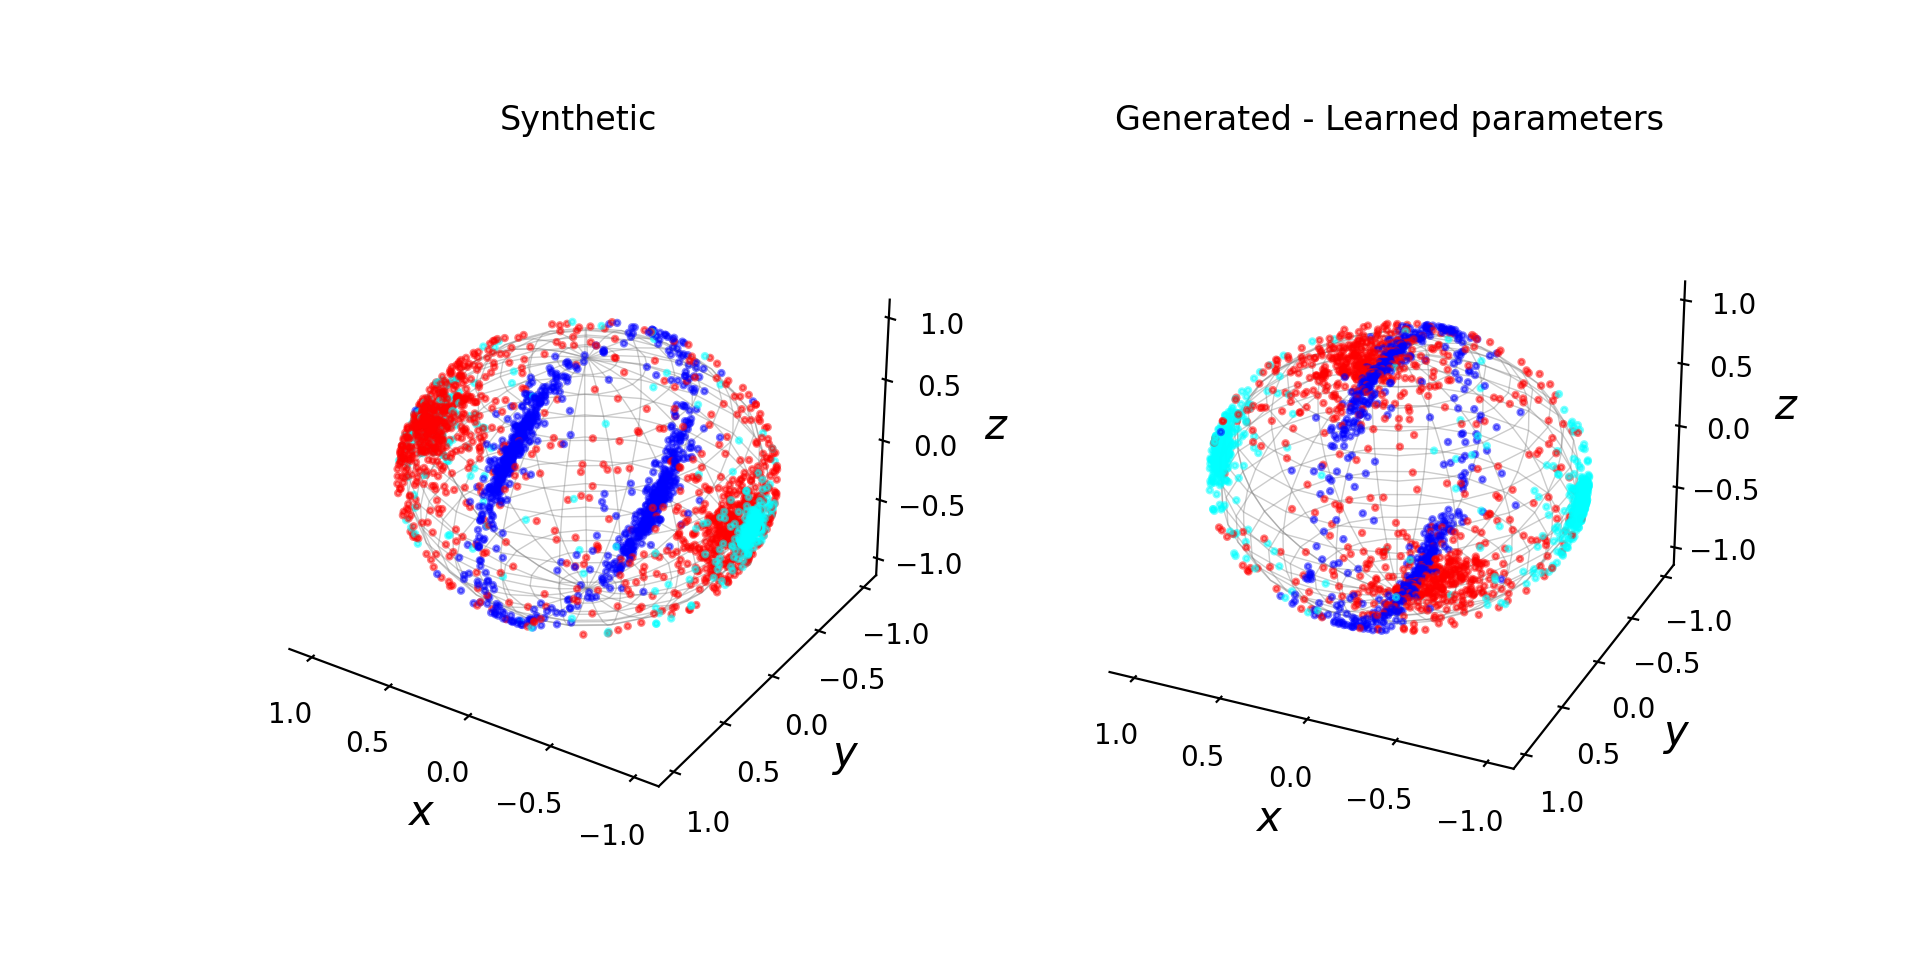

In [209]:
plt.close()
%matplotlib notebook

LearnX, Learn_cluster_id = syntheticMixture3D(pi=learned_pi, Sigmas=learned_sigma, num_points=3000, as_array=True)

fig = plt.figure(figsize=plt.figaspect(0.5))
id_2_color = {0: 'cyan', 1: 'red', 2: 'blue'}

X_gt_plot = torch.cat(tuple([*synX_emission]),0)
Z_seq_plot = torch.cat(tuple([*Z_seq]),0)


# Synthetic
ax = fig.add_subplot(1, 2, 1, projection='3d')
label_color = [id_2_color[id] for id in np.array(Z_seq_plot)]
ax.scatter(X_gt_plot[:, 0], X_gt_plot[:, 1], X_gt_plot[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Synthetic')

#Background
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)

# Learned
ax = fig.add_subplot(1, 2, 2, projection='3d')
label_color = [id_2_color[id] for id in Learn_cluster_id]
ax.scatter(LearnX[:, 0], LearnX[:, 1], LearnX[:, 2], s=4, alpha=0.5, c=label_color)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_zlabel('$z$', fontsize=15)
ax.set_title('Generated - Learned parameters')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.grid(False)

u = np.linspace(0, 2 * np.pi, 20)
v = np.linspace(0, np.pi, 20)

x = .95 * np.outer(np.cos(u), np.sin(v))
y = .95 * np.outer(np.sin(u), np.sin(v))
z = .95 * np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_wireframe(x, y, z, color='grey', rstride=1, cstride=1, alpha=0.4, linewidth=0.5)
ax.view_init(30, 135)
plt.show()

# Viterbi decode - Angular Central Gaussian - HMM

In [235]:
# 0 -> 2
# 1 -> 1
# 2 -> 0
d = {'0':2,'2':0}

In [236]:
best_paths, paths_probs = best_model.viterbi2(synX_emission)

<IPython.core.display.Javascript object>


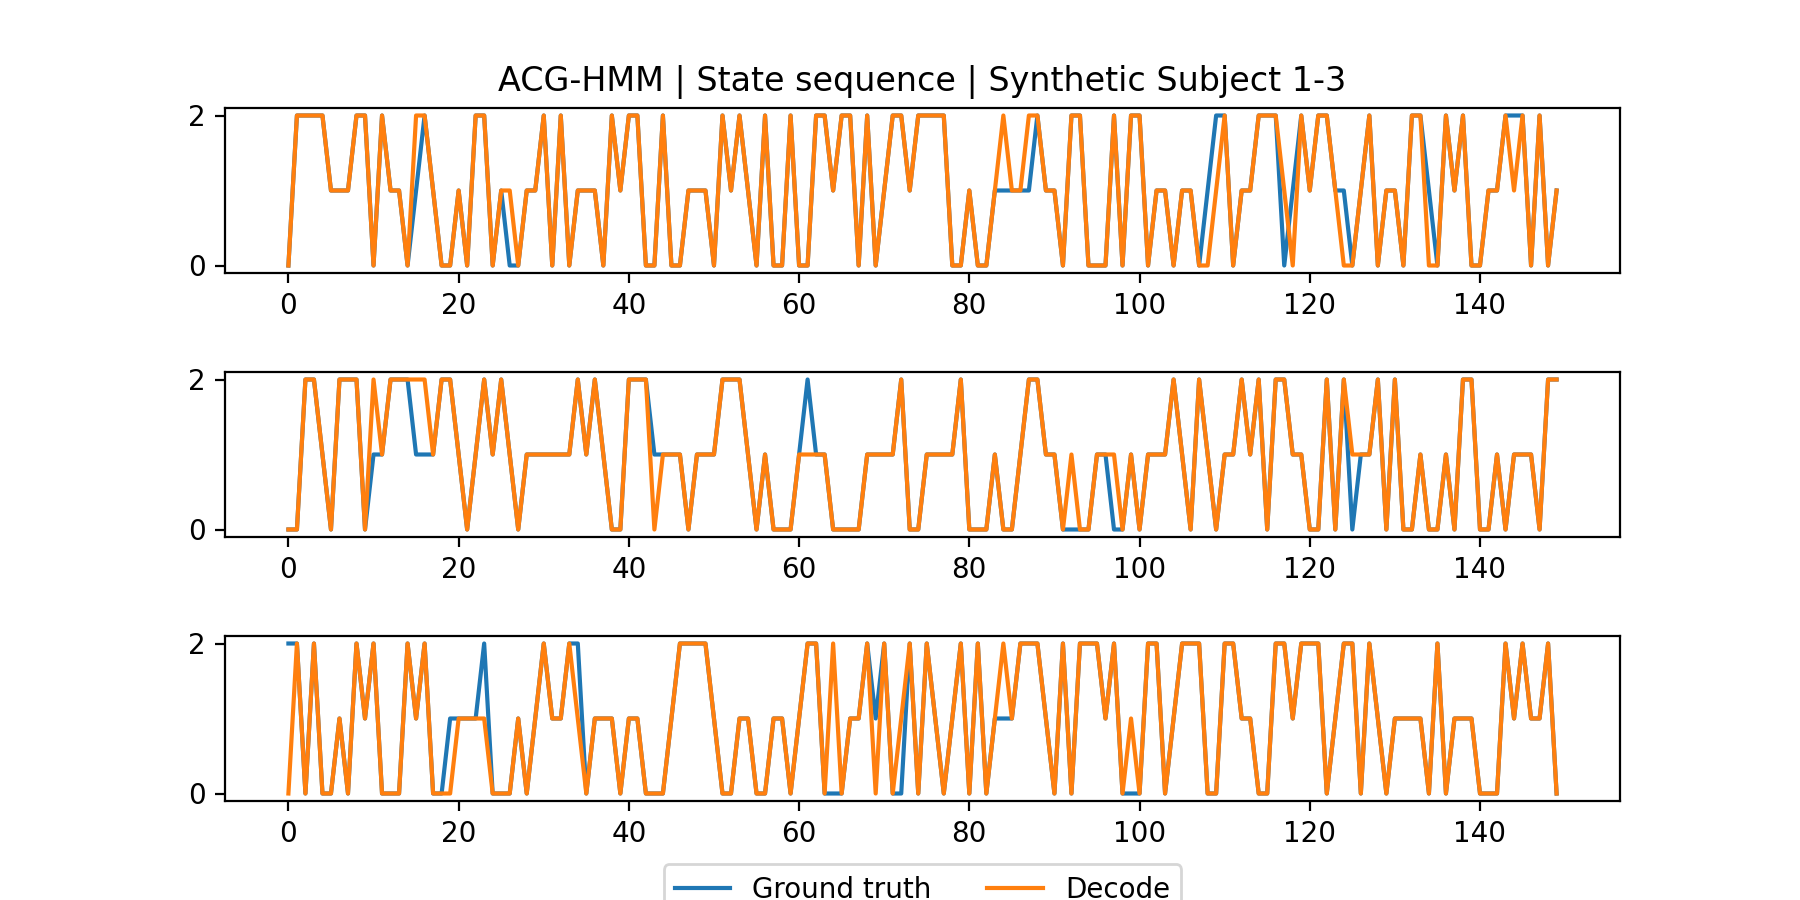

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [237]:
# sub = 4
# decode_path = list(best_paths[sub])
# decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
# decode_path.insert(0,0) # shift correnction
plt.close()
fig, ax = plt.subplots(3,1, figsize=(9,4.5))
fig.subplots_adjust(hspace=0.6)

for sub in range(3):
    decode_path = list(best_paths[sub])
    #decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    ax[sub].plot(Z_seq[sub], label='Ground truth')
    ax[sub].plot(decode_path[:-1], label='Decode')
    ax[0].set_title('ACG-HMM | State sequence | Synthetic Subject 1-3')
    ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
               ncol=2)

plt.show()

## ACG - HMM | NMI score

<IPython.core.display.Javascript object>


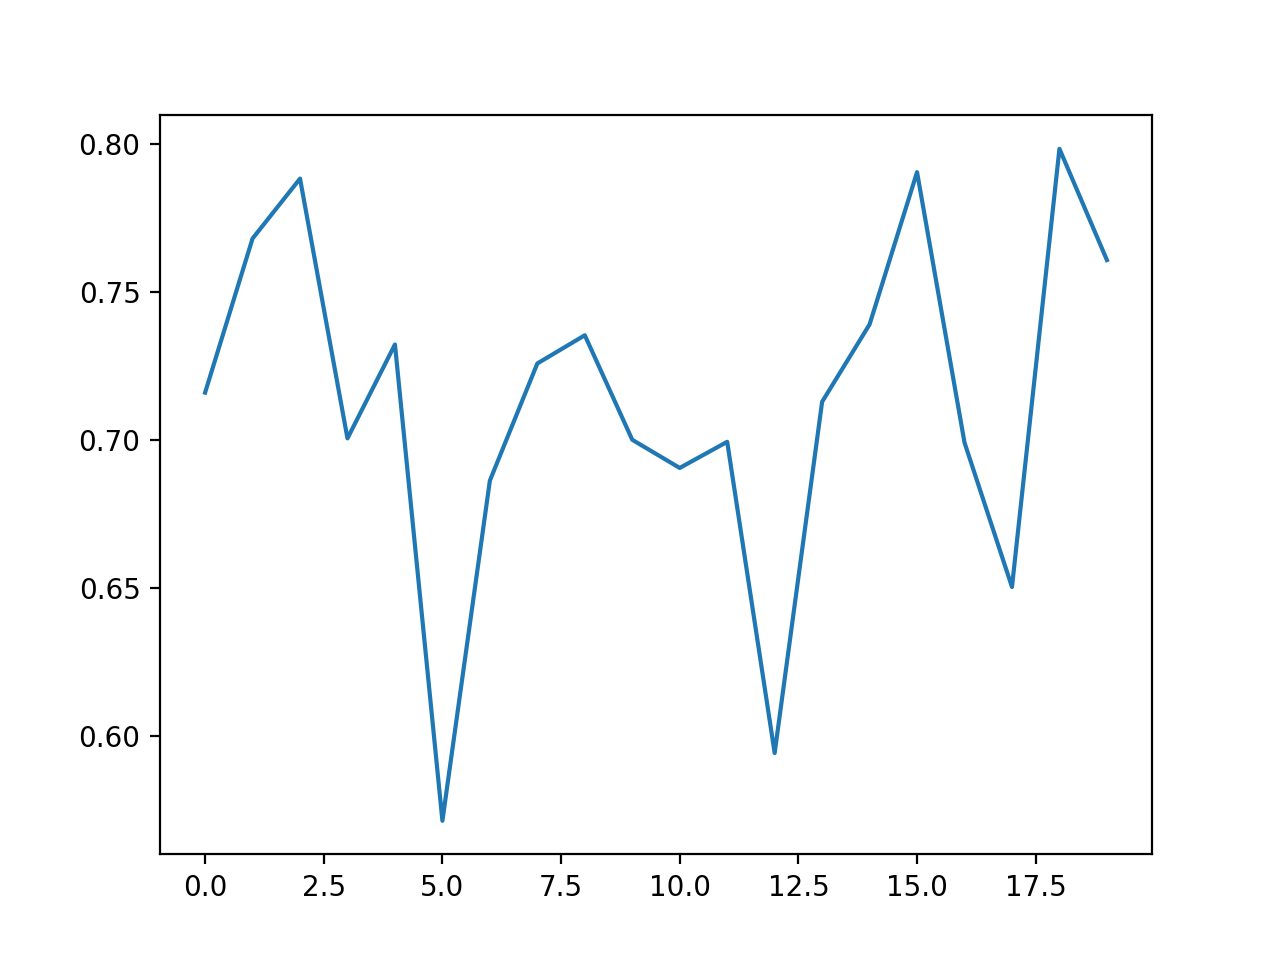

Average Watson NMI: 0.7129243313796799


In [238]:
d = {'0':2,'2':0} 
running_NMI = []
for sub in range(len(best_paths)):
    decode_path = list(best_paths[sub])
    decode_path = [Z if Z == 1 else d[str(Z)] for Z in decode_path]
    decode_path.insert(0,0) # shift correnction
    
    gt = Z_seq[sub]
    
    sub_NMI = NMI(gt,decode_path[:-1])
    running_NMI.append(sub_NMI)
plt.close()
plt.plot(running_NMI)
plt.show()
print(f'Average Watson NMI: {np.mean(running_NMI)}')